## Comparing model fits with random subsampling of features vs. PCA based on responses to Imagenet validation images

In [1]:
import numpy as np
import scipy.stats as stats
import nibabel.freesurfer.mghformat as mgh
import h5py

import sys

sys.path.append("..")

from paths import *
from constants import *

sys.path.append(CODE_PATH)

from utils.general_utils import make_iterable

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors as mcolors

In [31]:
subjid = ["01", "02", "03", "04", "05", "06", "07", "08"]
roi = "streams_shrink10"
hemi = "rh"
mapping_func = "PLS"
CV = 0
subsample_type = [1, 2]
ROI_NAMES = ['Early',
             'Midventral',
             'Midlateral',
             'Midparietal',
             'Ventral',
             'Lateral',
             'Parietal']
#models = [ "alexnet_torch", "vgg16", "resnet18", "resnet50", "resnet101"]
model_name = "resnet101"

In [32]:
means_nc = np.empty((len(subjid), len(ROI_NAMES)))
all_nc = [[[] for j in range(len(ROI_NAMES))] for i in range(len(subjid))]

means = np.empty((len(subjid), len(ROI_NAMES), len(subsample_type)))
all_rs = [[[[] for m in range(len(subsample_type))] for j in range(len(ROI_NAMES))] for i in range(len(subjid))]

for sidx, sid in enumerate(subjid):
    
    # Get ROI data
    mgh_file = mgh.load(
        NSDDATA_PATH
        + "freesurfer/subj"
        + sid
        + "/label/"
        + hemi
        + "."
        + roi
        + ".mgz"
    )
    streams = mgh_file.get_fdata()[:, 0, 0]
    streams_trim = streams[streams != 0]
    
    # Get noise ceiling estimates
    mgh_file = mgh.load(
        stem
        + "/data/nsddata_betas/ppdata/subj"
        + sid
        + "/nativesurface/betas_fithrf_GLMdenoise_RR/"
        + hemi
        + ".nc_3trials.mgh"
    )
    NC = mgh_file.get_fdata()[:, 0, 0]
    NC_trim = NC[streams != 0]
    
    num_vox = streams_trim.shape[0]
    
    for r in range(len(ROI_NAMES)):
        all_nc[sidx][r] = NC_trim[streams_trim==r+1]/100
        means_nc[sidx, r] = np.mean(NC_trim[streams_trim==r+1]/100)
    
    for suidx, subsample in enumerate(subsample_type):
        # get model fits
        load_path = (RESULTS_PATH 
                    + "fits/subj"
                    + sid
                    + "_"
                    + hemi
                    + "_"
                    + roi
                    + "_"
                    + model_name
                    + "_"
                    + mapping_func
                    + "_subsample_"
                    + str(subsample)
                    + "_"
                    + str(CV)
                    + "CV_fits.hdf5")
        fits = {}
        with h5py.File(load_path, "r") as f:
            keys = f.keys()
            for k in keys:
                fits[k] = f[k][:]
        
        if model_name == "alexnet":
            layer_keys = ALEXNET_LAYERS
        elif model_name == "alexnet_torch":
            layer_keys = ALEXNET_TORCH_LAYERS
        elif model_name == "vgg16":
            layer_keys = VGG16_LAYERS
        elif model_name == "resnet18":
            layer_keys = RESNET18_LAYERS
        elif model_name == "resnet50":
            layer_keys = RESNET50_LAYERS
        elif model_name == "resnet101":
            layer_keys == RESNET101_LAYERS
        layer_keys = [
            item
            for sublist in [
                [item] if type(item) is not list else item for item in layer_keys
            ]
            for item in sublist
        ]
        
        rs_by_layer = np.zeros((len(layer_keys), num_vox))
        for lix, layer in enumerate(layer_keys):
            rs_by_layer[lix,:] = fits[layer] #reshape dict to array
        max_rs = np.amax(rs_by_layer, axis=0)
            
        for r in range(len(ROI_NAMES)):
            all_rs[sidx][r][suidx] = max_rs[streams_trim==r+1]
            means[sidx, r, suidx] =  np.mean(max_rs[streams_trim==r+1])

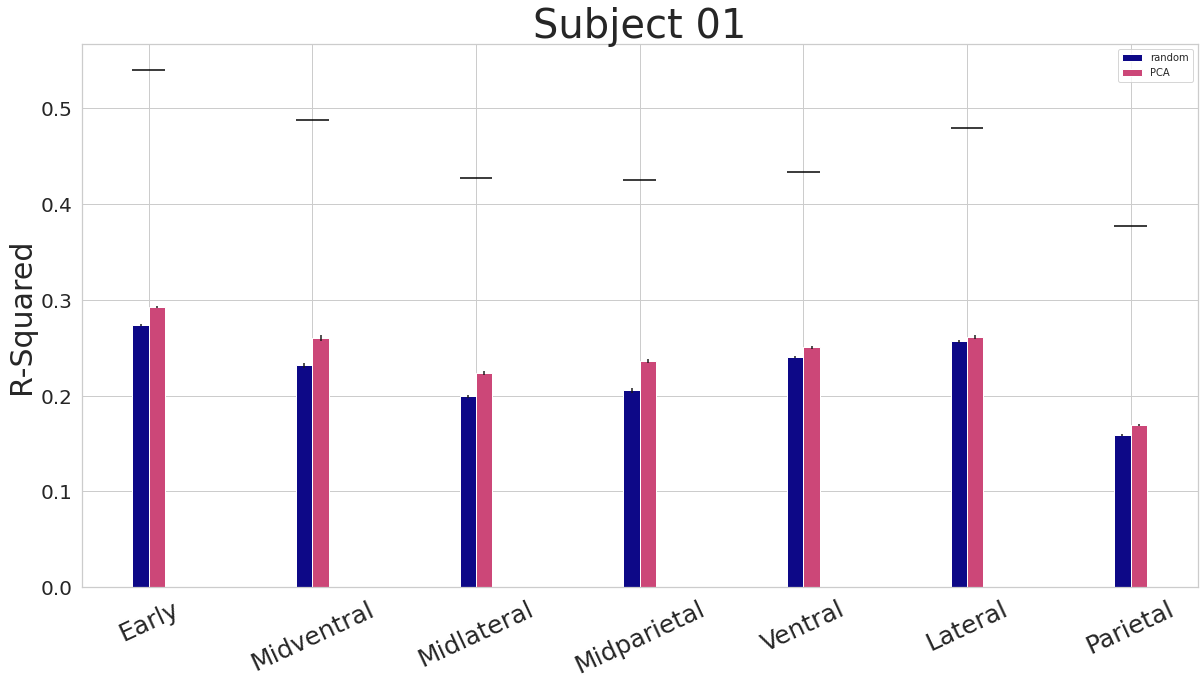

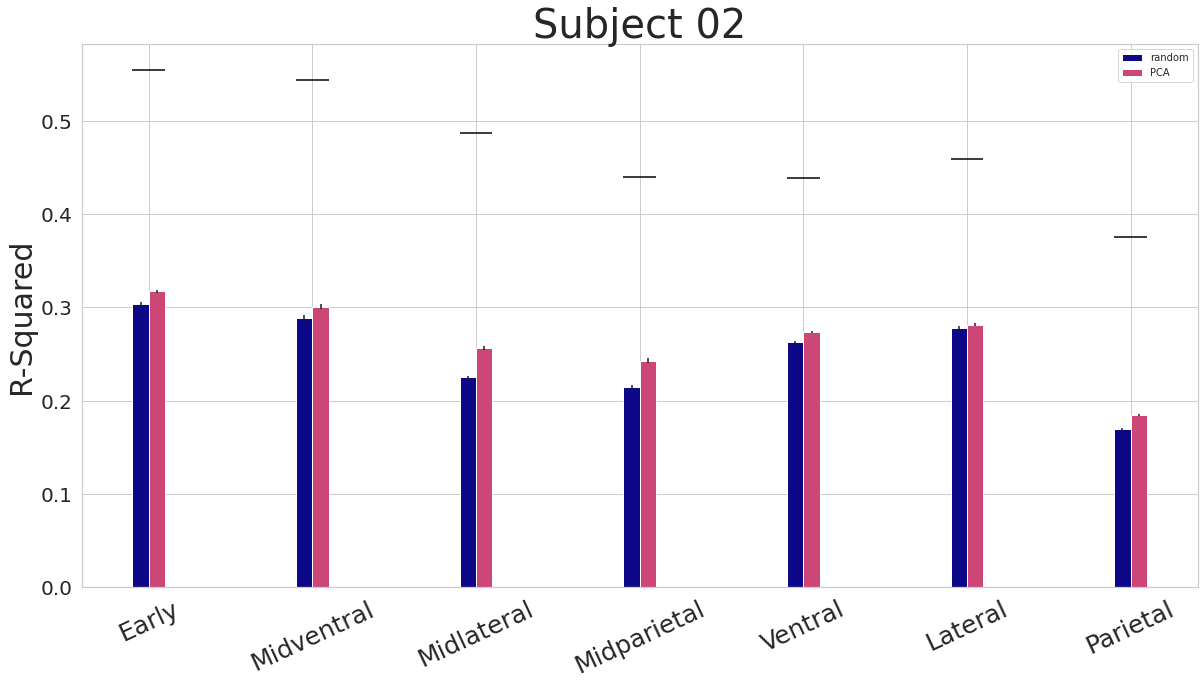

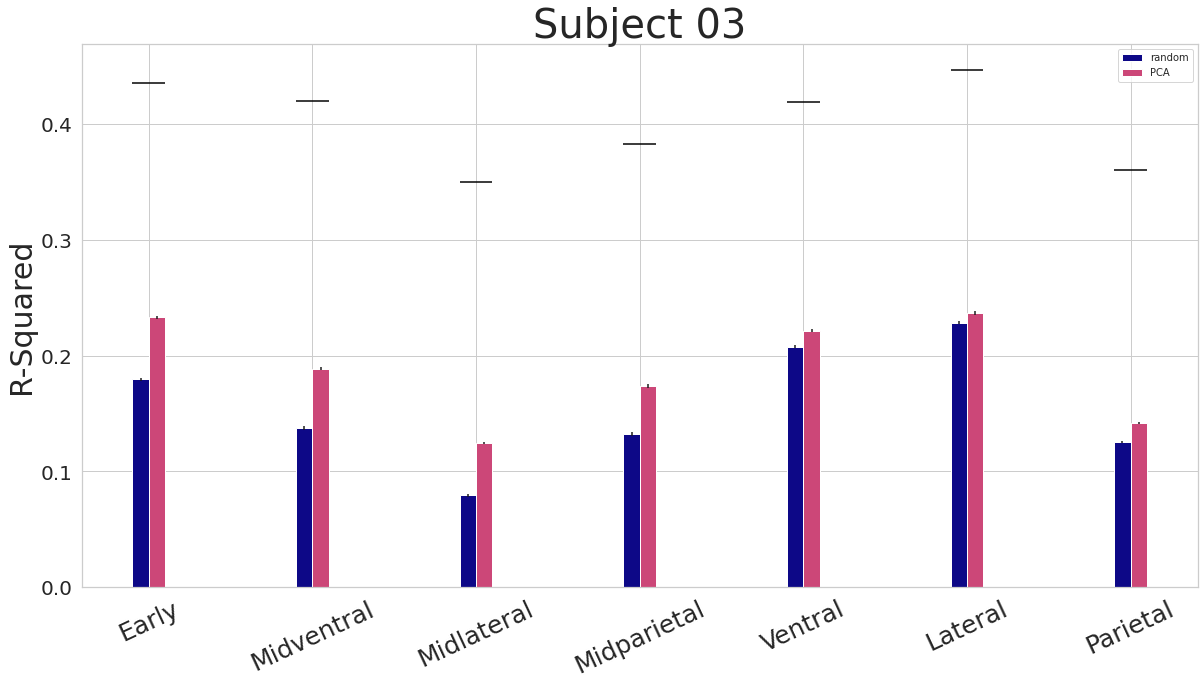

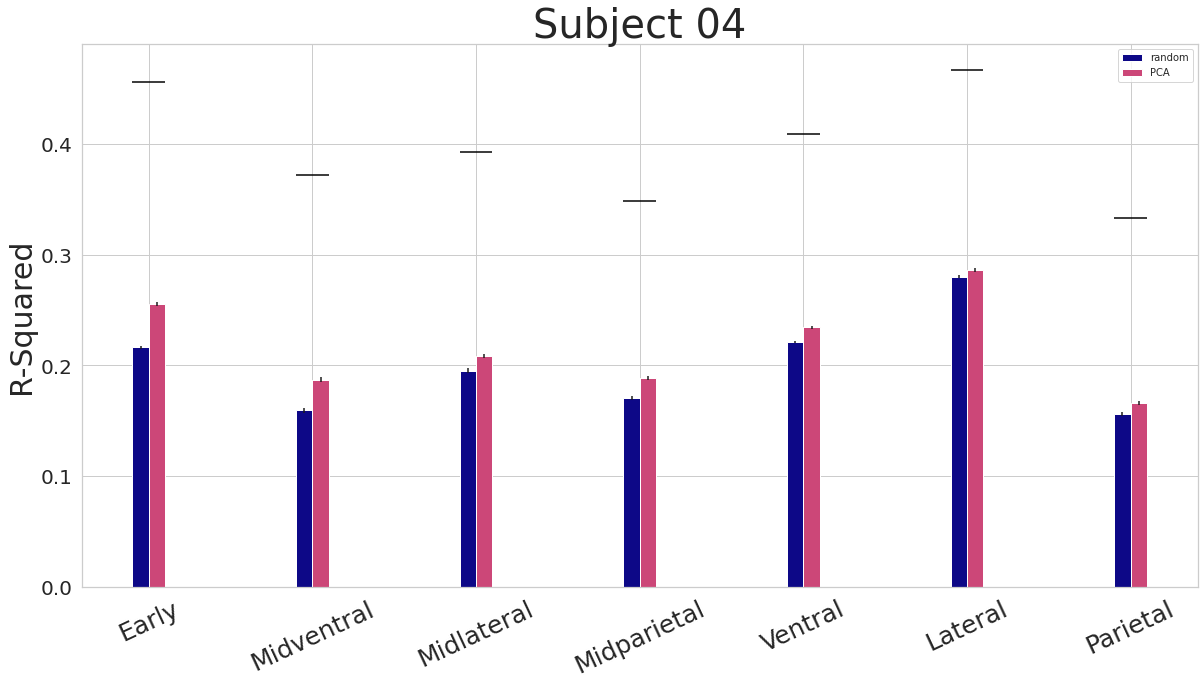

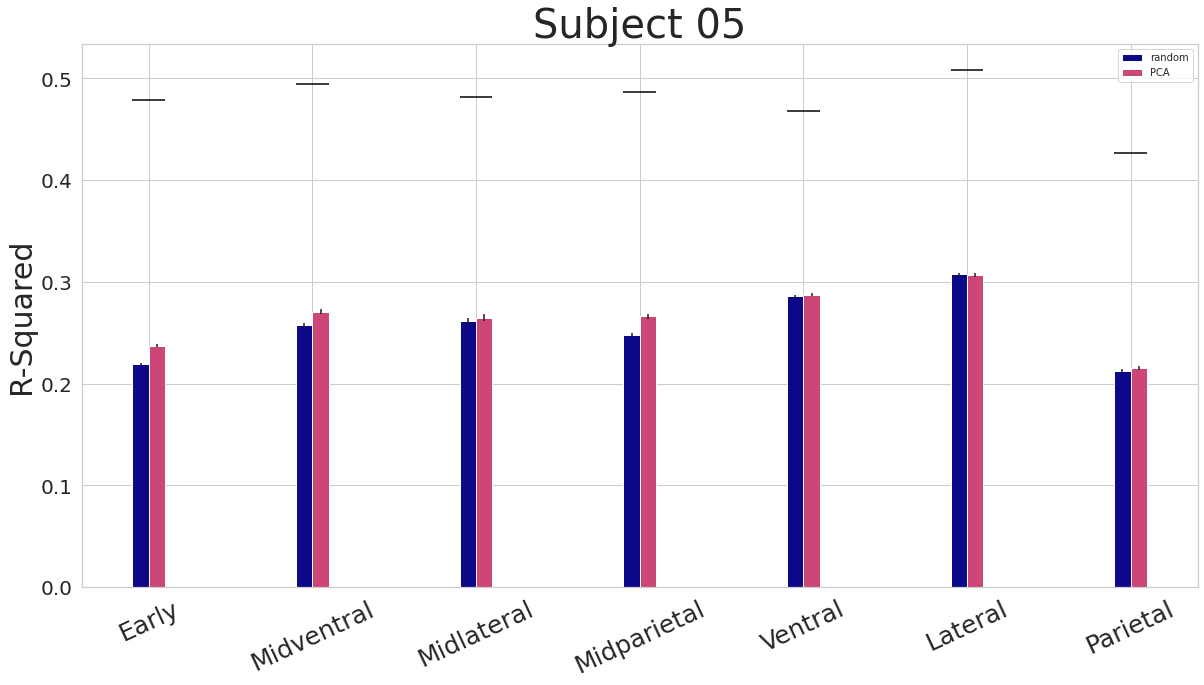

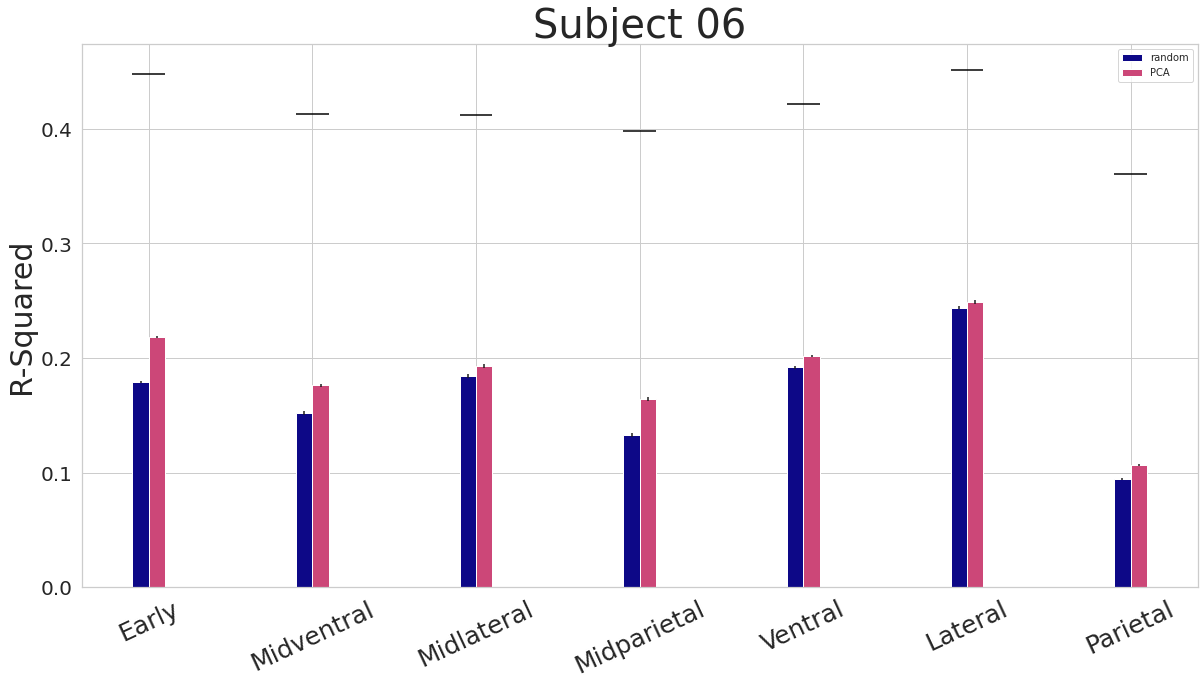

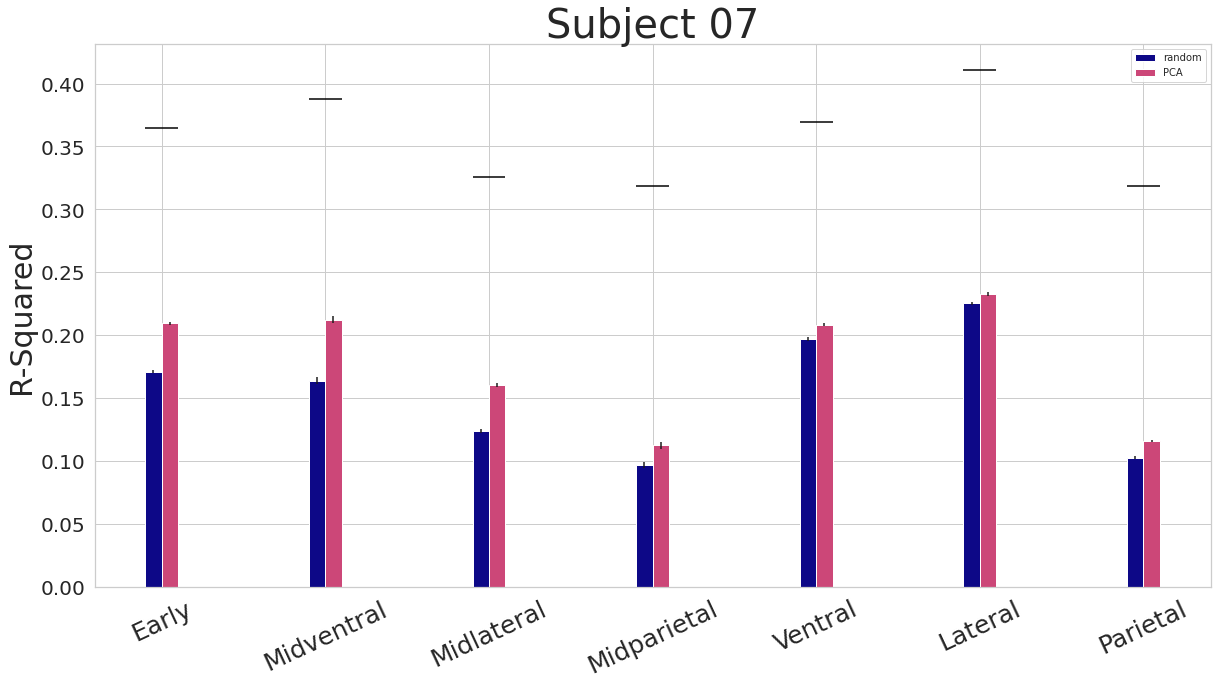

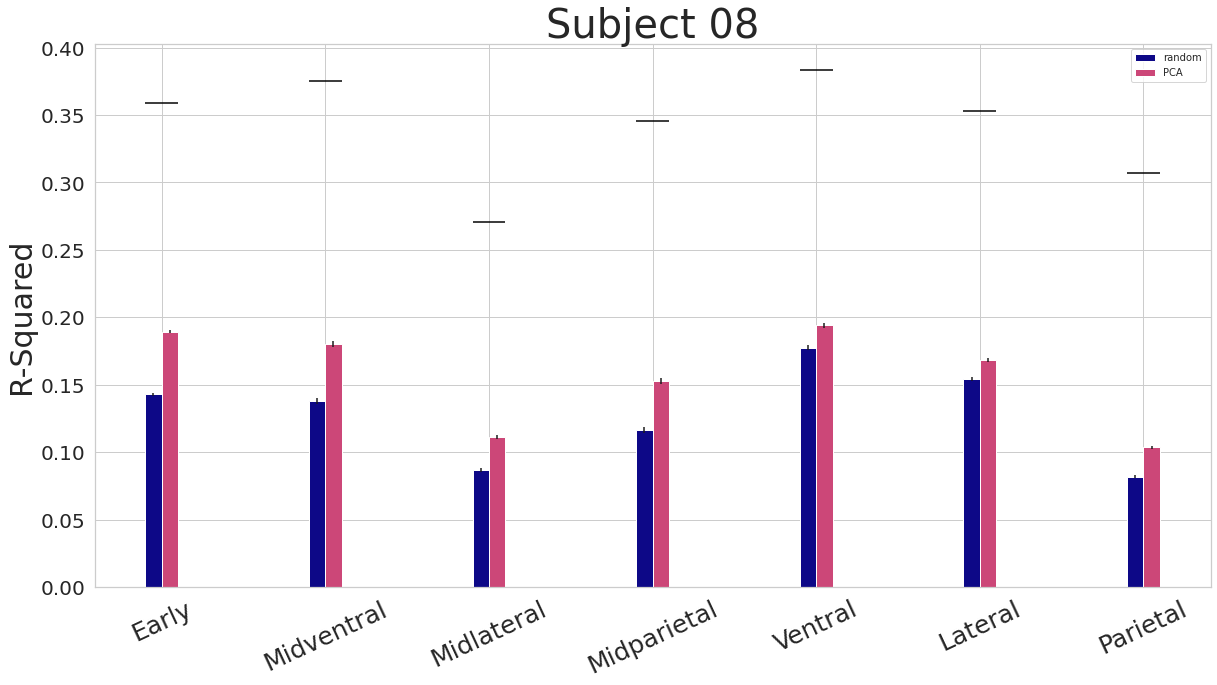

In [33]:
cmap = matplotlib.cm.get_cmap('plasma')
for sidx, sid in enumerate(subjid):
    fig, ax = plt.subplots(figsize=(20, 10))
    fig.patch.set_facecolor('white')

    subj_nc = [np.mean(all_nc[sidx][r]) for r in range(len(ROI_NAMES))]
    
    # set width of bars
    barWidth = 0.1
    
    for suidx, subsample in enumerate(subsample_type):
        if subsample == 1:
            label = "random"
        elif subsample == 2:
            label = "PCA"
            
        rgba = cmap(suidx/len(subsample_type))
        
        data = [np.mean(all_rs[sidx][r][suidx]) for r in range(len(ROI_NAMES))]
        error = [stats.sem(all_rs[sidx][r][suidx]) for r in range(len(ROI_NAMES))]

        # Set position of bar on X axis
        if suidx == 0:
            base = np.arange(len(data))
            r = [x - (barWidth)*(len(subsample_type)/2) for x in base]
        else:
            r = [x + barWidth for x in prev_r]

        # Make the plot
        plt.bar(r, data, yerr=error, width=barWidth, edgecolor='white', color = rgba, label=label)
        
        prev_r = r

    # iterate over range of number of rows
    for r in range(len(ROI_NAMES)):
        ax.hlines(y = subj_nc[r], 
                  xmin = r - barWidth/2 - (len(subsample_type)/2)*barWidth, 
                  xmax = r - barWidth/2 + (len(subsample_type)/2)*barWidth,
                  color = 'black')

    plt.xticks([r - barWidth/2 for r in range(len(data))], ROI_NAMES, rotation=25, fontsize=25);

    plt.ylabel('R-Squared',size = 30)
    plt.yticks(fontsize=20)

    title_string = "Subject "
    title_string += sid
    plt.title(title_string,size = 40)

    # Create legend & Show graphic
    plt.legend(fontsize=10)

    save_path = (RESULTS_PATH 
                + "fits/figures/subj"
                + sid
                + "_"
                + hemi
                + "_"
                + roi
                + "_"
                + model_name
                + "_fitcomp_bysubsample.png")

    fig.savefig(save_path)
    plt.show()

### Averaged across subjects

In [34]:
nc_mean_across_subj = np.hstack((np.mean(means_nc, axis=0),np.mean(means_nc, axis=0)))

In [35]:
d = {
    'subject_name': np.concatenate((np.tile('subj01',len(ROI_NAMES)*len(subsample_type)), 
                                    np.tile('subj02',len(ROI_NAMES)*len(subsample_type)), 
                                    np.tile('subj03',len(ROI_NAMES)*len(subsample_type)),
                                    np.tile('subj04',len(ROI_NAMES)*len(subsample_type)),
                                    np.tile('subj05',len(ROI_NAMES)*len(subsample_type)),
                                    np.tile('subj06',len(ROI_NAMES)*len(subsample_type)),
                                    np.tile('subj07',len(ROI_NAMES)*len(subsample_type)),
                                    np.tile('subj08',len(ROI_NAMES)*len(subsample_type)))),
    'roi': np.tile(ROI_NAMES, len(subjid)*len(subsample_type)),
    'Subsample': np.ravel(np.tile(np.ravel([np.tile(m, len(ROI_NAMES)) for m in subsample_type]), len(subjid))),
    'r_squared': np.swapaxes(means,1,2).ravel(),
    'nc': np.ravel(np.tile(means_nc,len(subsample_type)))
    
}

In [36]:
df = pd.DataFrame(d,columns=['subject_name','roi','Subsample', 'r_squared', 'nc'])
df  

,subject_name,roi,Subsample,r_squared,nc
0,subj01,Early,1,0.273249,0.540384
1,subj01,Midventral,1,0.231866,0.488188
2,subj01,Midlateral,1,0.199355,0.427014
3,subj01,Midparietal,1,0.205408,0.425549
4,subj01,Ventral,1,0.240026,0.433113
...,...,...,...,...,...
107,subj08,Midlateral,2,0.111162,0.271028
108,subj08,Midparietal,2,0.152898,0.345459
109,subj08,Ventral,2,0.193995,0.383733
110,subj08,Lateral,2,0.168473,0.352622


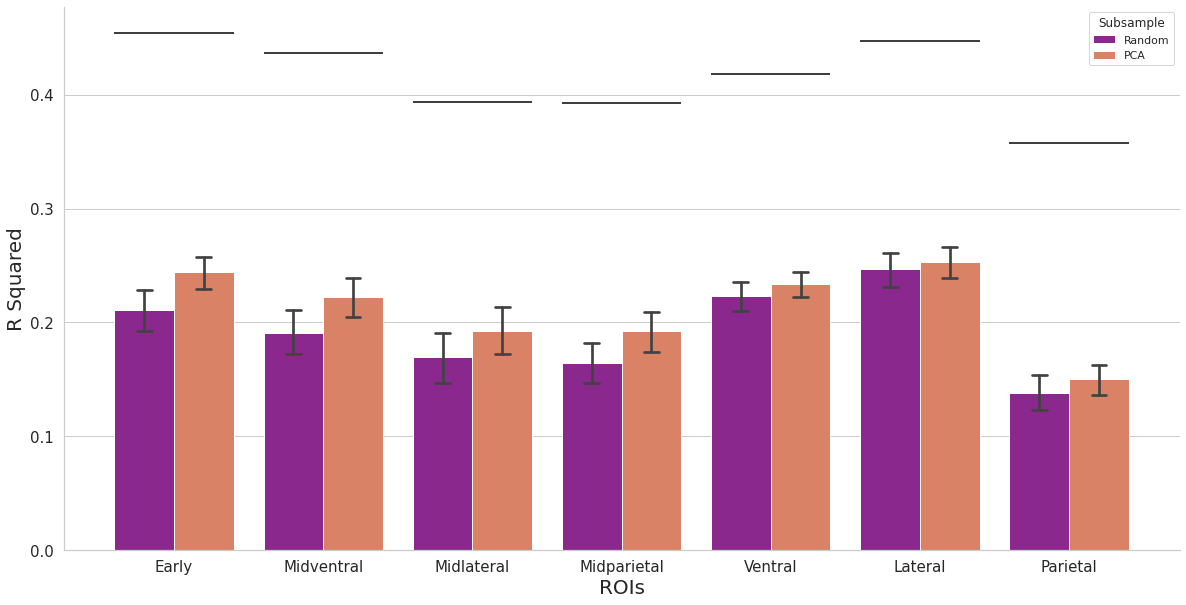

In [37]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x="roi", y="r_squared", hue="Subsample",palette='plasma',data=df, ci=68, capsize = .1, ax=ax)
# iterate over range of number of rows
for i in range(7):
    ax.hlines(y = nc_mean_across_subj[i], xmin = i-0.4, xmax = i+0.4,
              color = 'black')
#for idx, bar in enumerate(ax.patches):
#    bar.set_color(roi_colors[idx])
#    bar.set_edgecolor("w")
    
ax.set_xlabel('ROIs', fontsize=20)
ax.set_ylabel('R Squared', fontsize=20)
ax.tick_params(labelsize=15)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

leg = ax.get_legend()
new_labels = ['Random', 'PCA']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
    
save_path = (RESULTS_PATH 
                + "fits/figures/groupavg_"
                + hemi
                + "_"
                + roi
                + "_"
                + model_name
                + "_fitcomp_bysubsample.png")

fig.savefig(save_path)
